# ST2195 - Coursework Part 2 (Python)

In [ ]:
# Student Details
## Student Name: Trixie Grace Mok
## Student Number: 220659213

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import DateOffset
import datetime
from datetime import timedelta
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Set the working directory
os.chdir("C:/Users/Trixie/Desktop/From WDBLACK/Year 2 UOL Subjects/Programming Assignment/Final/Question 2/dataverse_files")


airports = pd.read_csv("airports.csv")
carriers = pd.read_csv("carriers.csv")
planes = pd.read_csv("plane-data.csv")

flights_1999 = pd.read_csv("1999.csv.bz2", compression='bz2')
flights_2000 = pd.read_csv("2000.csv.bz2", compression='bz2')
flights_2001 = pd.read_csv("2001.csv.bz2", compression='bz2')
flights_2002 = pd.read_csv("2002.csv.bz2", compression='bz2')
flights_2003 = pd.read_csv("2003.csv.bz2", compression='bz2')
flights_2004 = pd.read_csv("2004.csv.bz2", compression='bz2')
flights_2005 = pd.read_csv("2005.csv.bz2", compression='bz2')
flights_2006 = pd.read_csv("2006.csv.bz2", compression='bz2')
flights_2007 = pd.read_csv("2007.csv.bz2", compression='bz2')
flights_2008 = pd.read_csv("2008.csv.bz2", compression='bz2')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe4 in position 343: invalid continuation byte

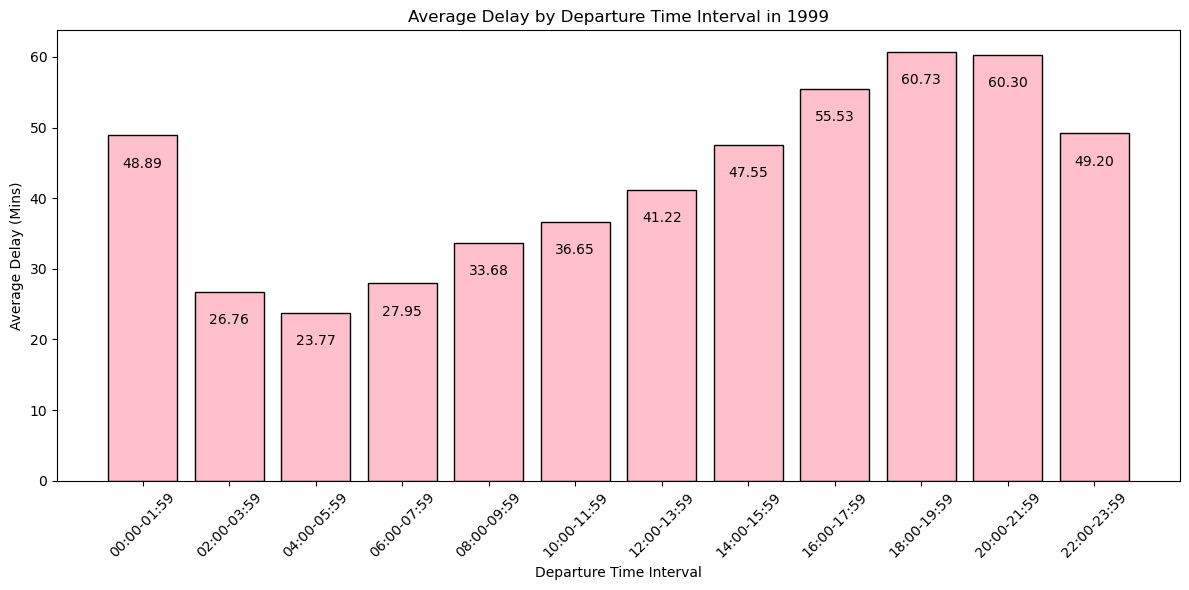

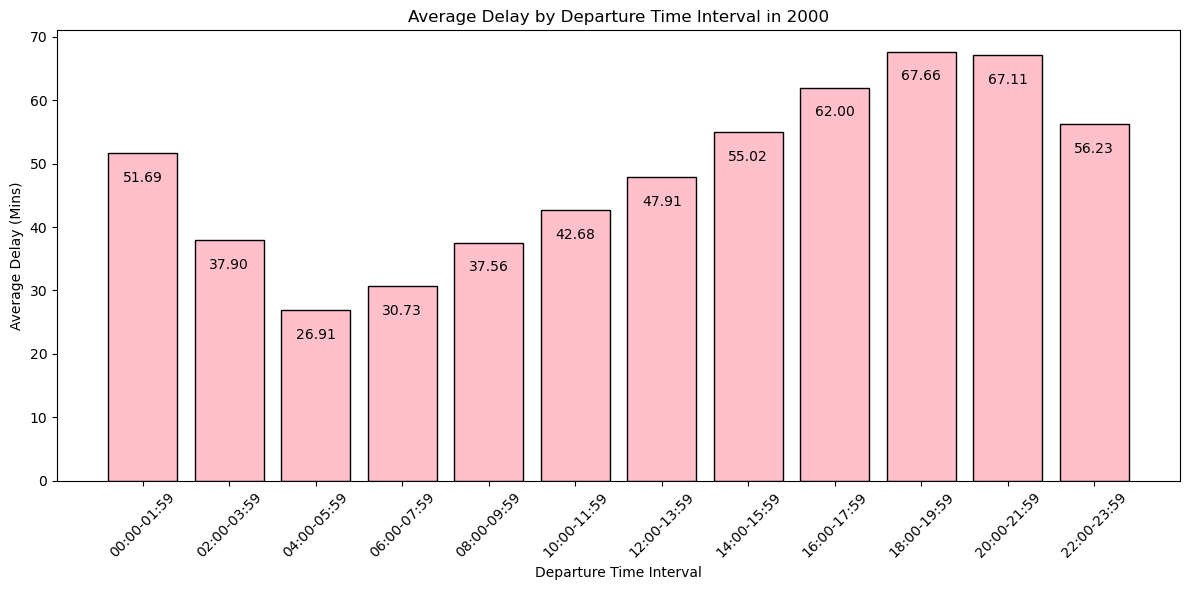

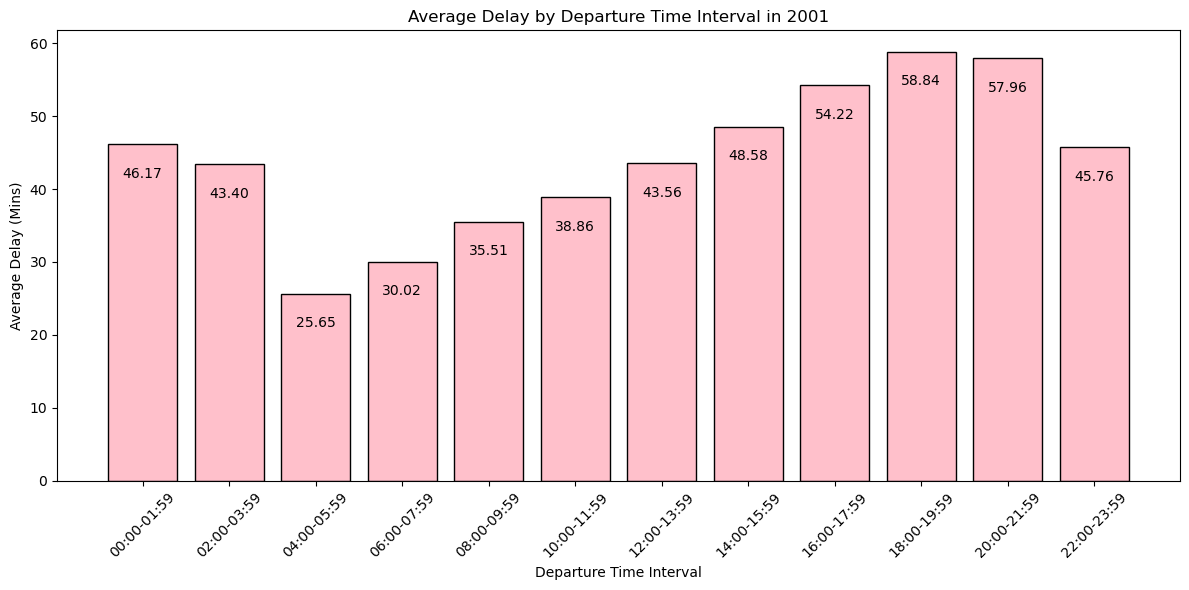

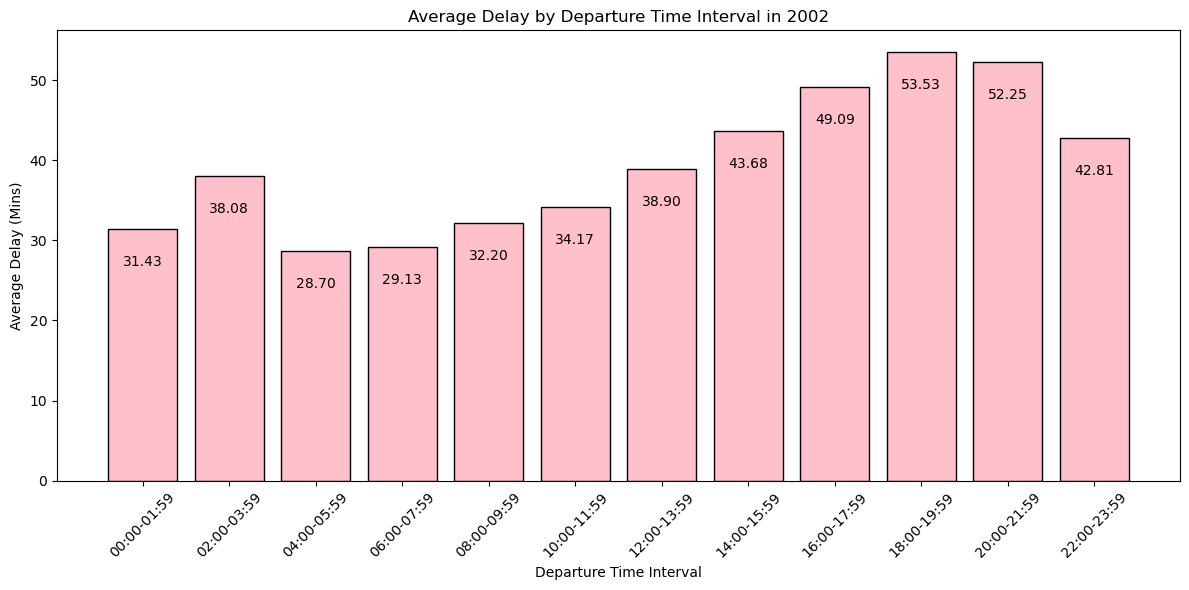

C:\Users\Trixie\AppData\Local\Temp\ipykernel_26004\2041163431.py:18: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  year_flight = pd.read_csv(f"{year}.csv.bz2", compression='bz2', encoding='utf-8')


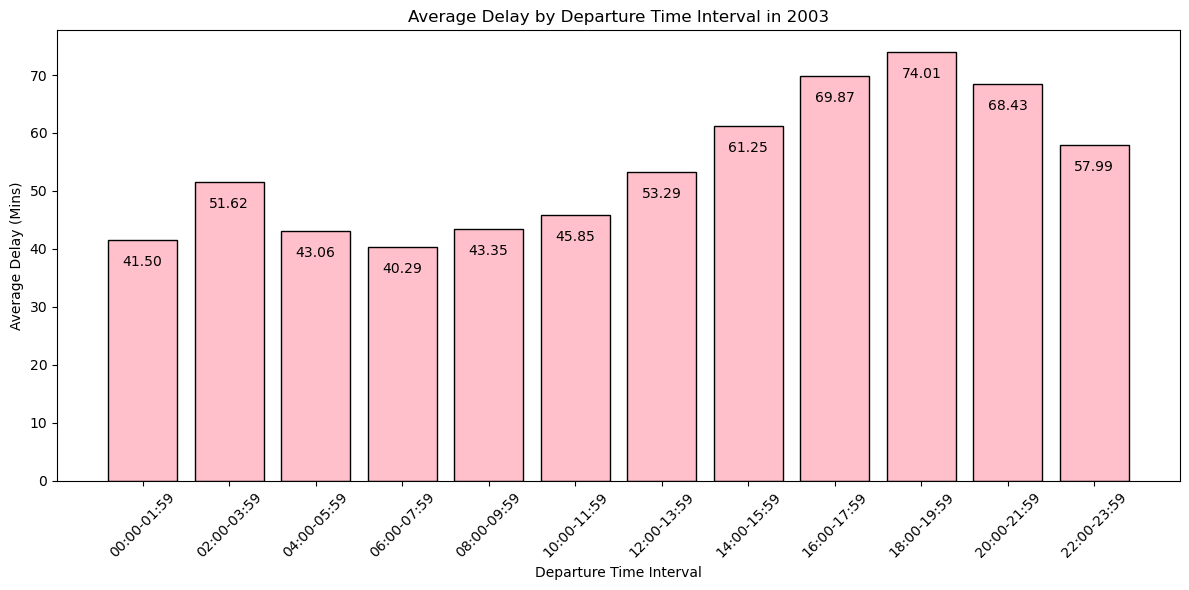

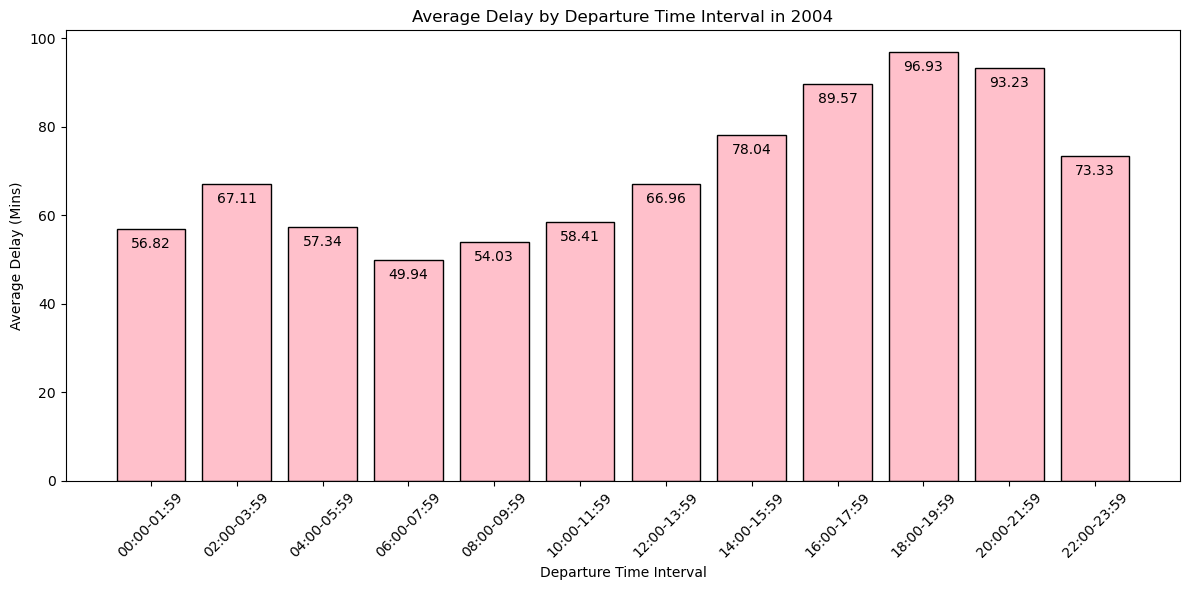

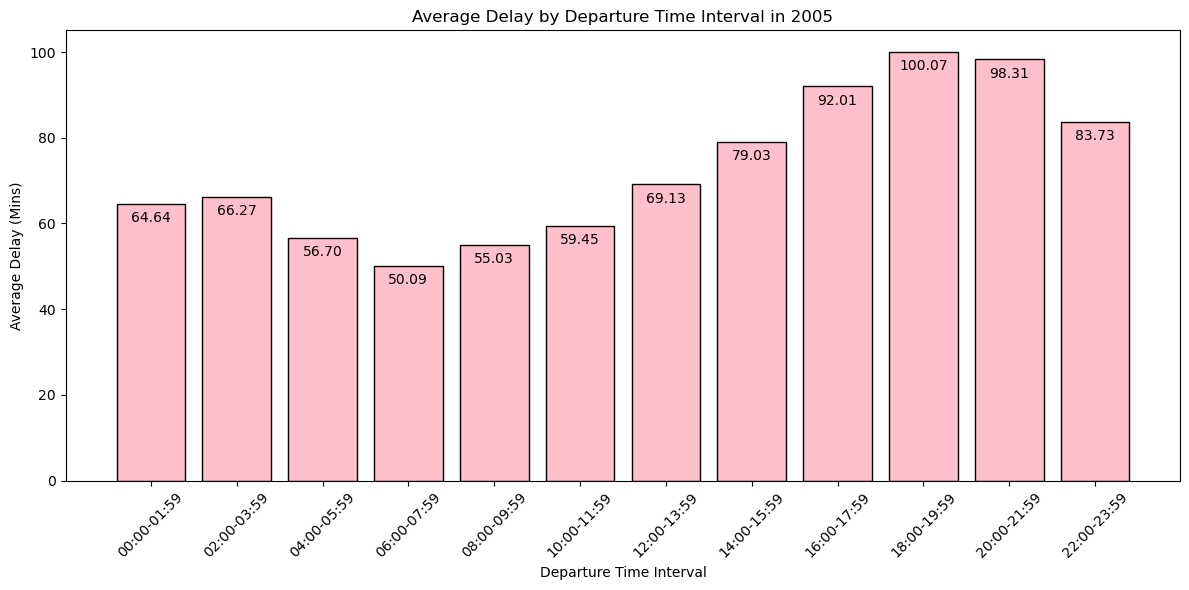

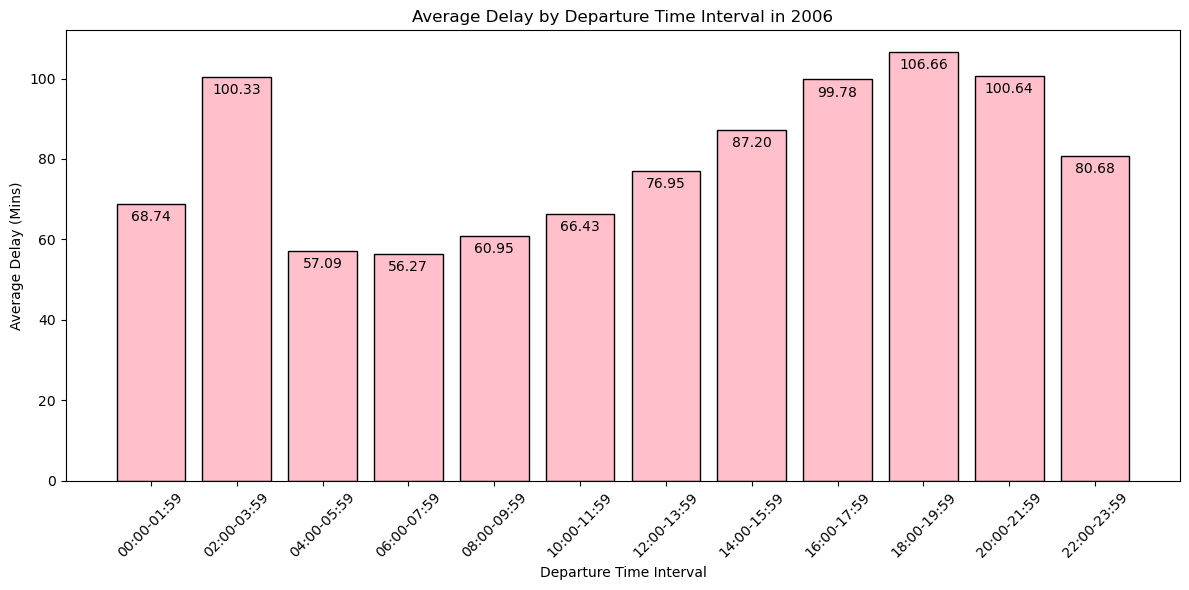

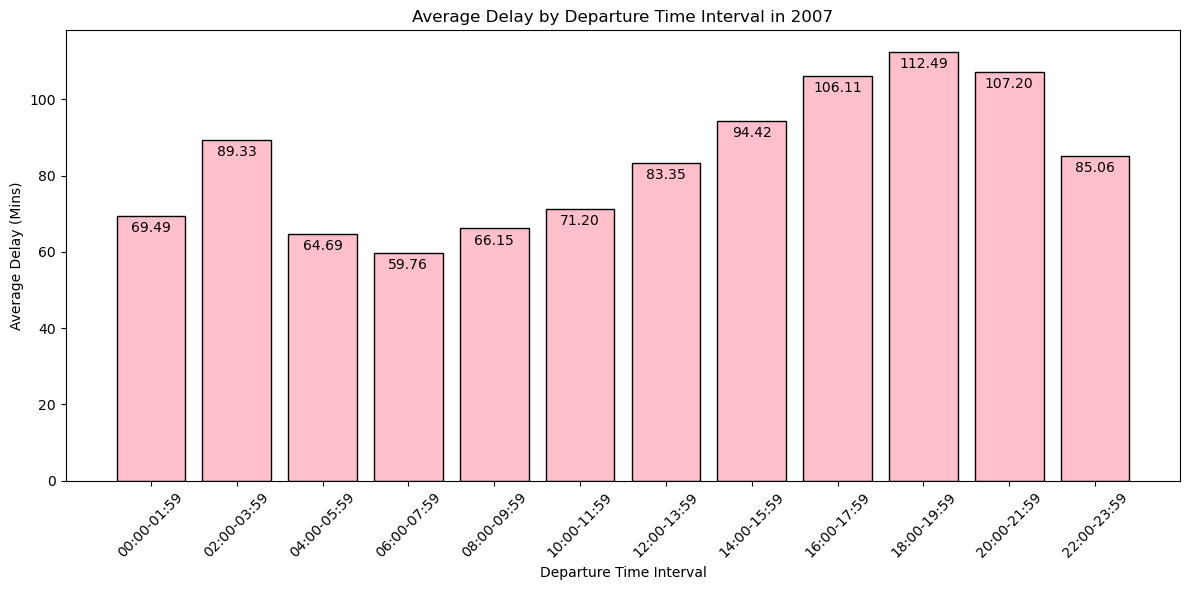

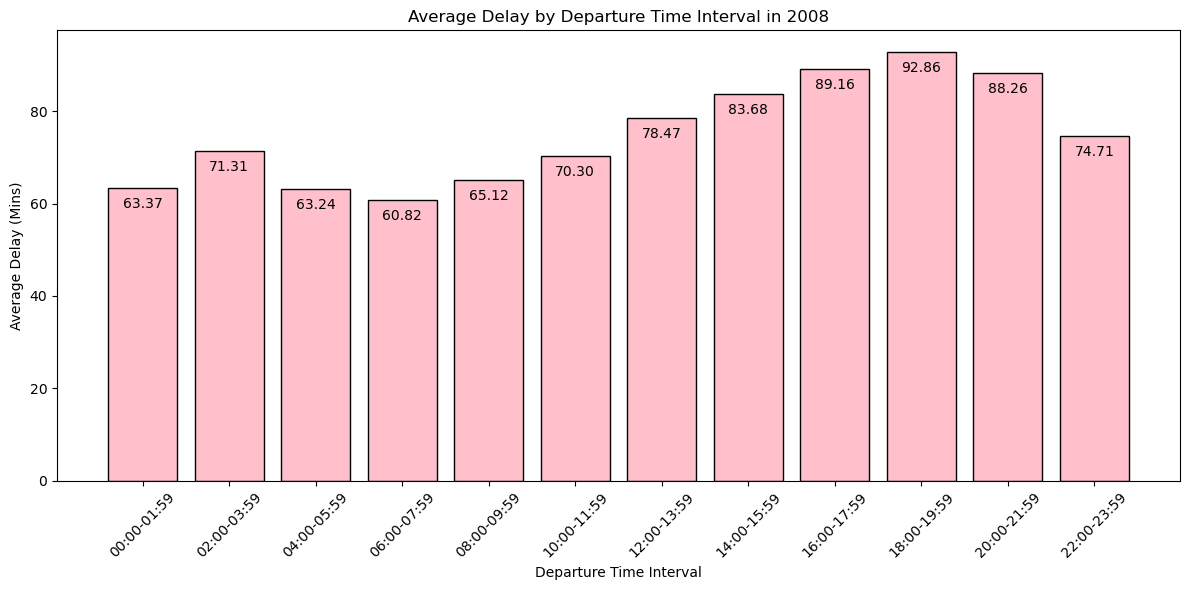

In [3]:

# Define a function to classify CRSDepTime into 2-hour intervals
def classify_time_intervals(time):
    if pd.isnull(time):
        return None  
    hour = int(time / 100)  # Extract the hour component.
    intervals = [
        "00:00-01:59", "02:00-03:59", "04:00-05:59",
        "06:00-07:59", "08:00-09:59", "10:00-11:59",
        "12:00-13:59", "14:00-15:59", "16:00-17:59",
        "18:00-19:59", "20:00-21:59", "22:00-23:59"
    ]
    if hour < 0 or hour > 23:
        return None  # Filter out-of-range hours later by returning None
    return intervals[hour // 2]

for year in range(1999, 2009):
    try:
        year_flight = pd.read_csv(f"{year}.csv.bz2", compression='bz2', encoding='utf-8')
    except UnicodeDecodeError:
        year_flight = pd.read_csv(f"{year}.csv.bz2", compression='bz2', encoding='ISO-8859-1')

    # Clean the data
    year_flight_cleaned = year_flight[(year_flight["Cancelled"] == 0) & (year_flight["Diverted"] == 0)].drop_duplicates()

    # Classify flights under 2-hour constant time frames
    year_flight_cleaned['dt_intervals'] = year_flight_cleaned['CRSDepTime'].apply(classify_time_intervals)

    # Drop rows where dt_intervals is none
    year_flight_cleaned = year_flight_cleaned.dropna(subset=['dt_intervals'])

    # Fill missing values in delay columns
    delay_columns = ["ArrDelay", "DepDelay", "CarrierDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "WeatherDelay"]
    year_flight_cleaned[delay_columns] = year_flight_cleaned[delay_columns].fillna(method='ffill')

    # Calculate total delay and filter flights with any delay
    year_flight_cleaned['total_delay'] = year_flight_cleaned[delay_columns].sum(axis=1)
    year_flight_delays = year_flight_cleaned[year_flight_cleaned['total_delay'] > 0]

    # Aggregate average delay by time intervals
    best_time_day = year_flight_delays.groupby('dt_intervals')[['total_delay']].mean().reset_index()

    # Plot average delay for each time interval
    plt.figure(figsize=(12, 6))
    bars = plt.bar(best_time_day['dt_intervals'], best_time_day['total_delay'], color='pink', edgecolor='black')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height - 5, f'{height:.2f}', ha='center', va='bottom', fontsize = 10)

    plt.xticks(rotation=45)
    plt.title(f'Average Delay by Departure Time Interval in {year}')
    plt.xlabel('Departure Time Interval')
    plt.ylabel('Average Delay (Mins)')
    plt.tight_layout()
    plt.show()


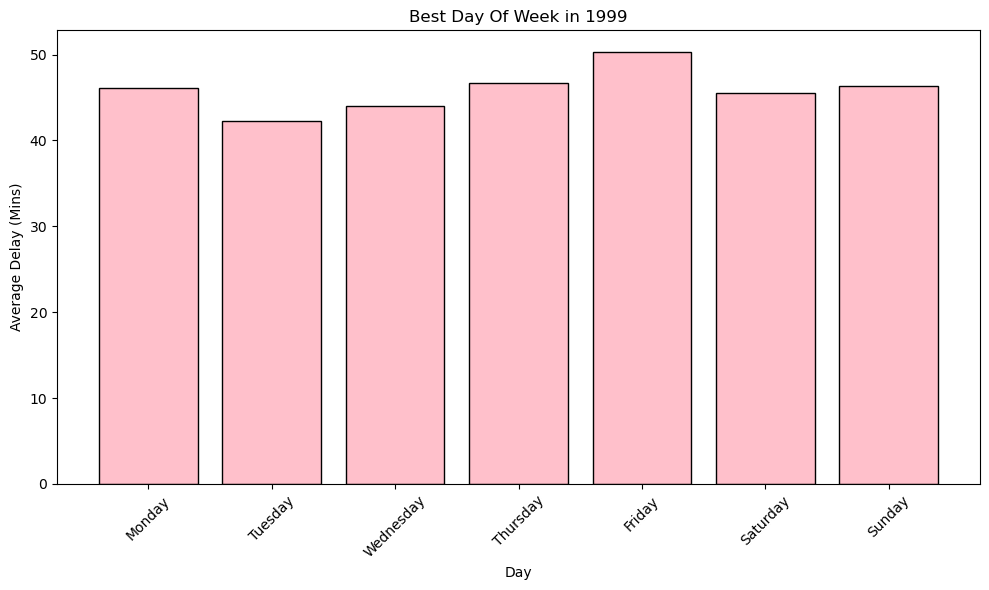

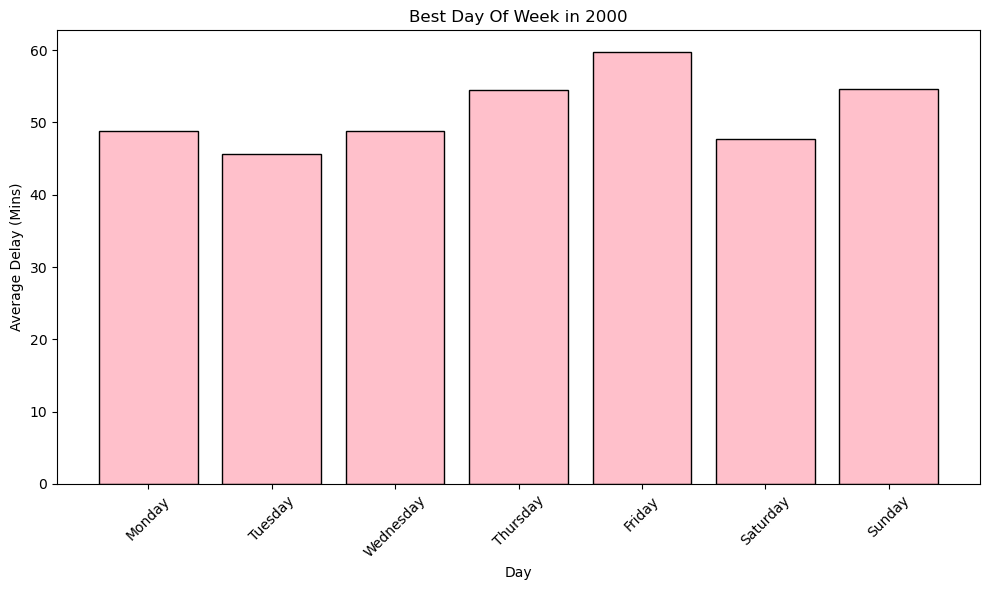

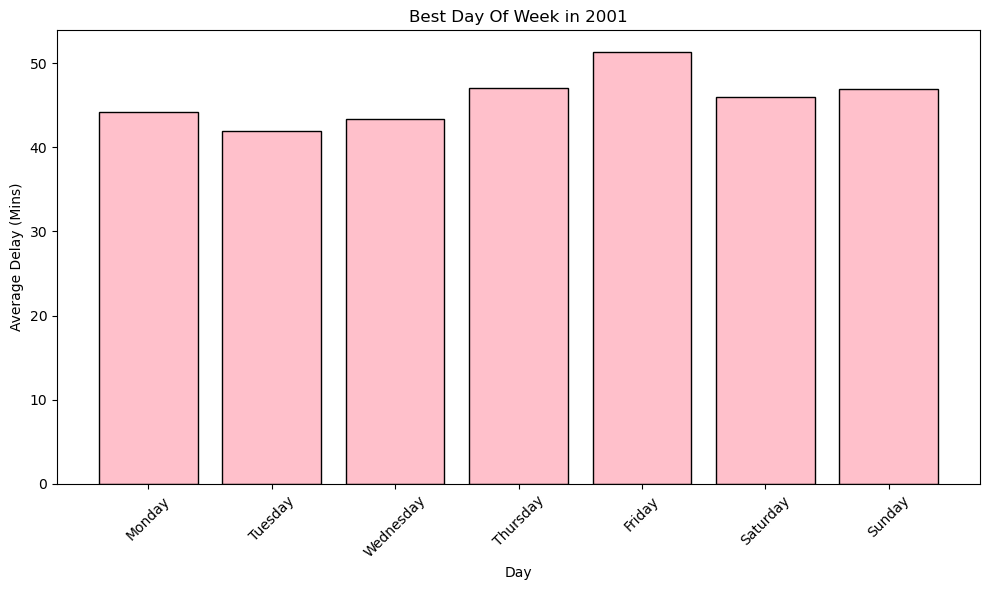

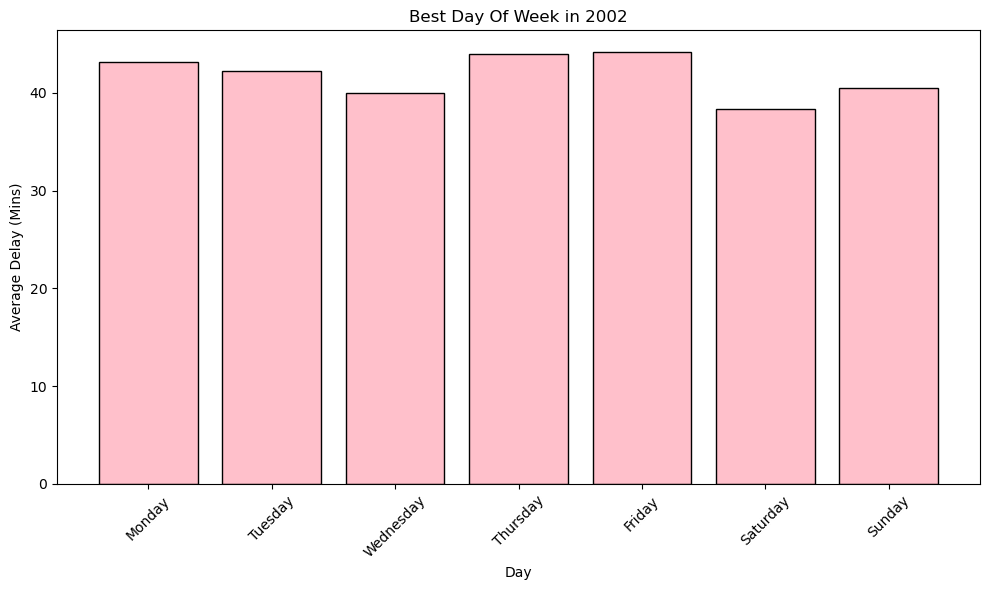

C:\Users\Trixie\AppData\Local\Temp\ipykernel_37304\3895440501.py:5: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  year_flight = pd.read_csv(f"{year}.csv.bz2", compression='bz2', encoding='utf-8')


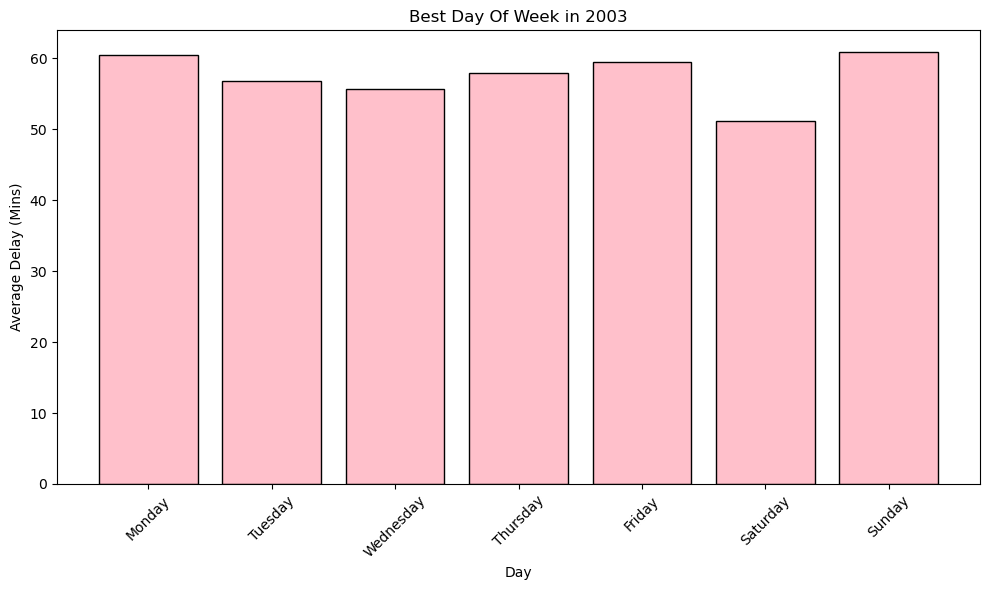

MemoryError: Unable to allocate 256. KiB for an array with shape (32768,) and data type int64

In [63]:

for year in range(1999, 2009):
    try:
        year_flight = pd.read_csv(f"{year}.csv.bz2", compression='bz2', encoding='utf-8')
    except UnicodeDecodeError:
        year_flight = pd.read_csv(f"{year}.csv.bz2", compression='bz2', encoding='ISO-8859-1')

    # Clean the data
    year_flight_cleaned = year_flight[(year_flight["Cancelled"] == 0) & (year_flight["Diverted"] == 0)].drop_duplicates()

    # Fill missing values in delay columns
    delay_columns = ["ArrDelay", "DepDelay", "CarrierDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "WeatherDelay"]
    year_flight_filled = year_flight_cleaned.fillna(method='ffill')
    
    # Calculate total delay and filter flights with any delay
    year_flight_filled['total_delay'] = year_flight_filled[delay_columns].sum(axis=1, skipna=True)
    year_flight_delays = year_flight_filled[year_flight_filled['total_delay'] > 0]

    # Group to find the best day of the week
    best_day_week = year_flight_delays.groupby('DayOfWeek')['total_delay'].mean().reset_index().sort_values('DayOfWeek')

    all_days = pd.DataFrame({'DayOfWeek': range(1, 8)})
    best_day_week = pd.merge(all_days, best_day_week, on='DayOfWeek', how='left').fillna(0) 

    day_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
    best_day_week['DayOfWeek'] = best_day_week['DayOfWeek'].map(day_names)  

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(best_day_week['DayOfWeek'], best_day_week['total_delay'], color='pink', edgecolor='black')
    plt.xticks(rotation=45)  
    plt.title(f'Best Day Of Week in {year}')
    plt.xlabel('Day')
    plt.ylabel('Average Delay (Mins)')
    plt.tight_layout()
    plt.show()


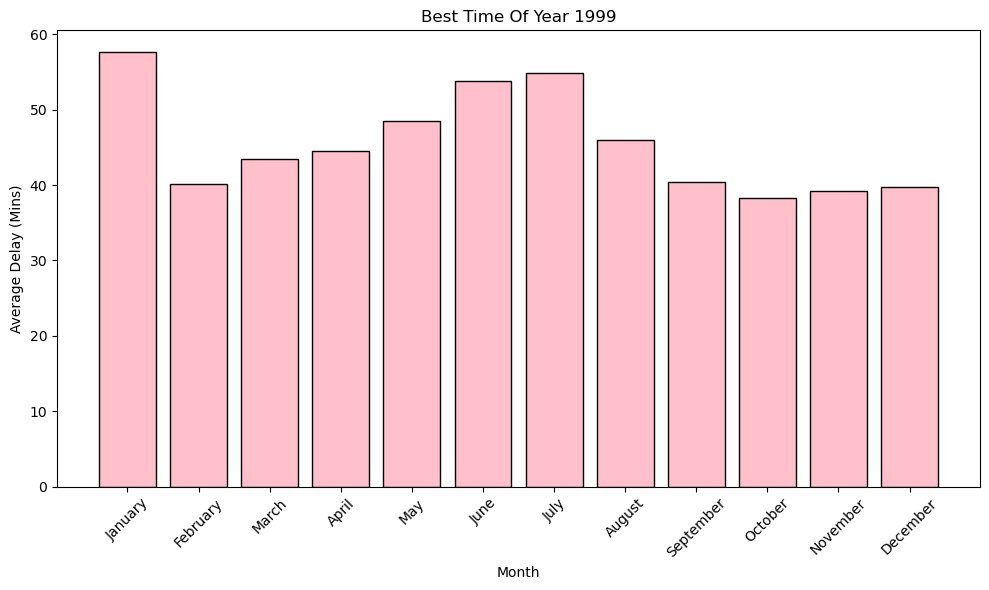

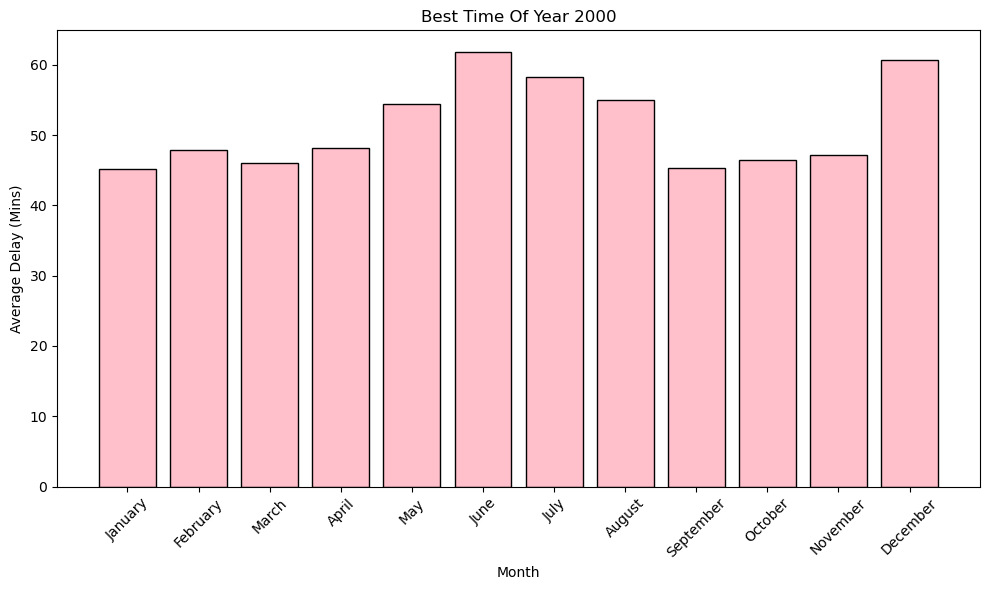

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe4 in position 343: invalid continuation byte

In [5]:


all_months_df = pd.DataFrame({'Month': range(1, 13)})

for year in range(1999, 2009):
    try:
        year_flight = pd.read_csv(f"{year}.csv.bz2", compression='bz2', encoding='utf-8')
    except UnicodeDecodeError:
        year_flight = pd.read_csv(f"{year}.csv.bz2", compression='bz2', encoding='ISO-8859-1')
 
    # clean  data
    year_flight_cleaned = year_flight[(year_flight["Cancelled"] == 0) & (year_flight["Diverted"] == 0)].drop_duplicates()

    # Fill missing values in delay columns with last observation carried forward
    delay_columns = ["ArrDelay", "DepDelay", "CarrierDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "WeatherDelay"]
    year_flight_cleaned.fillna(method='ffill', inplace=True)

    # total delay and filter flights with any delay
    year_flight_cleaned['total_delay'] = year_flight_cleaned[delay_columns].sum(axis=1, skipna=True)
    year_flight_delays = year_flight_cleaned[year_flight_cleaned['total_delay'] > 0]

    # Group to find average delay by month
    best_month_year = year_flight_delays.groupby('Month')['total_delay'].mean().reset_index()

    # Ensure all months are present
    best_month_year = pd.merge(all_months_df, best_month_year, on='Month', how='right').fillna(method='ffill')

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(best_month_year['Month'], best_month_year['total_delay'], color='pink', edgecolor='black')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation=45)
    ax.set_title(f'Best Time Of Year {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Delay (Mins)')

    plt.tight_layout()
    plt.show()


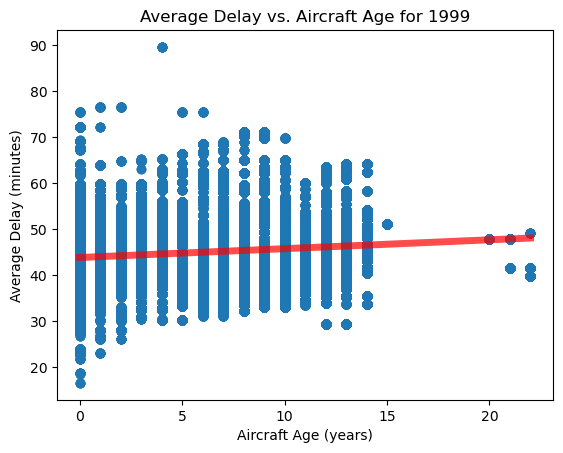

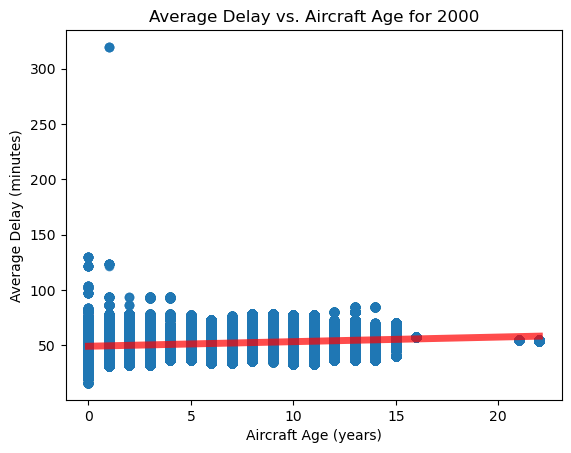

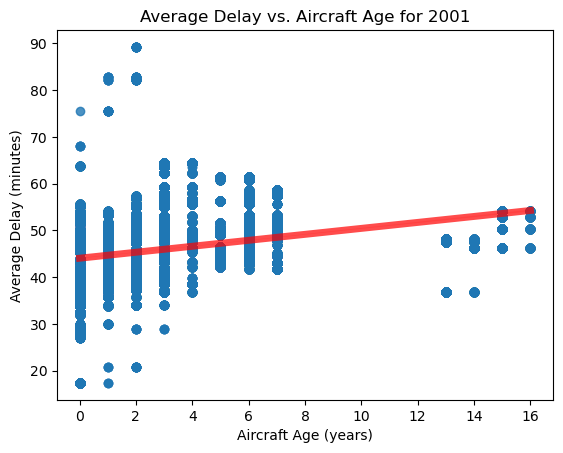

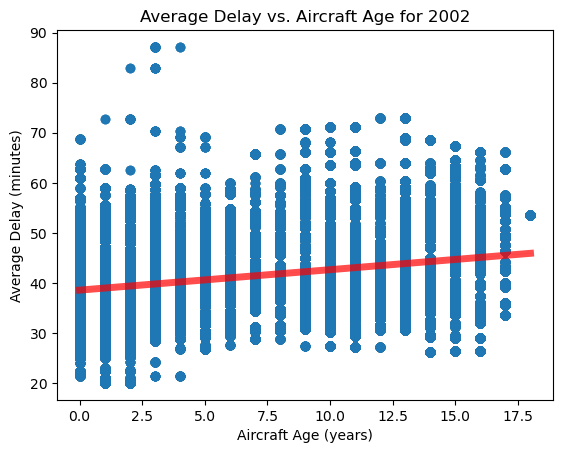

C:\Users\Trixie\AppData\Local\Temp\ipykernel_37304\3777690730.py:11: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  year_flight = pd.read_csv(f"{year}.csv.bz2", compression='bz2', encoding='utf-8')


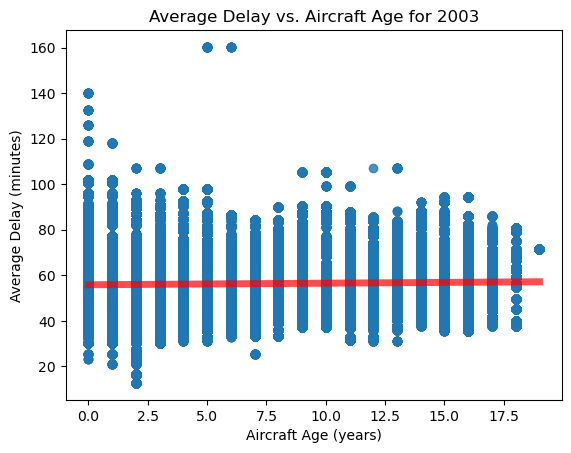

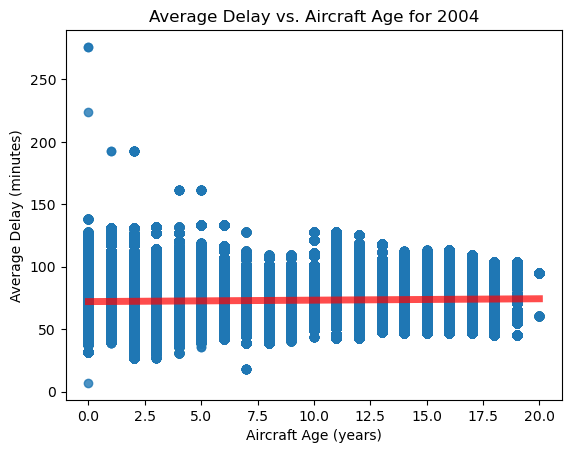

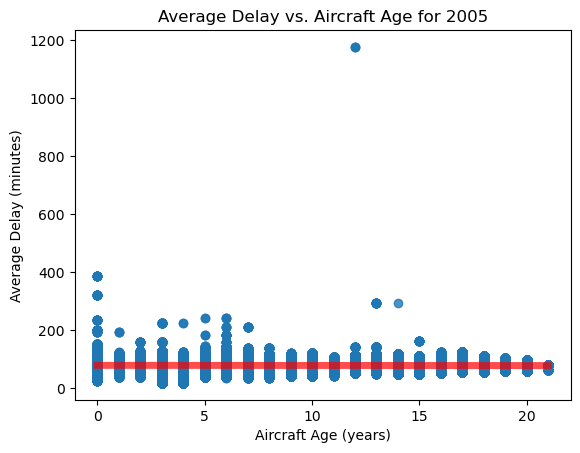

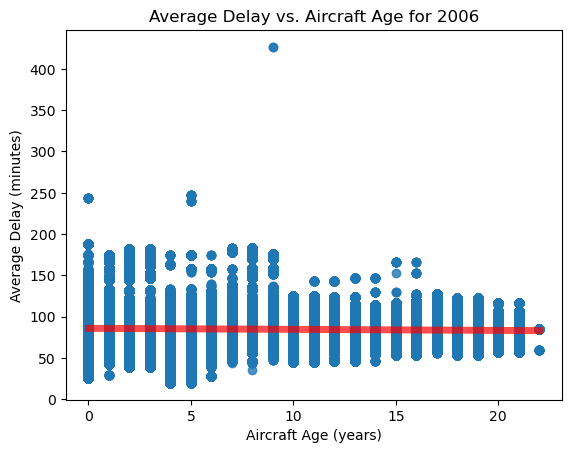

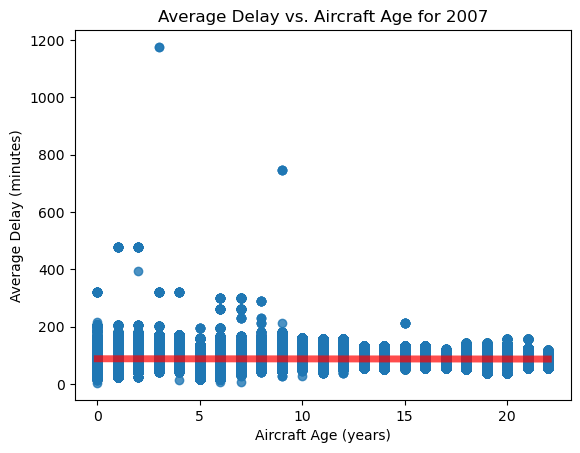

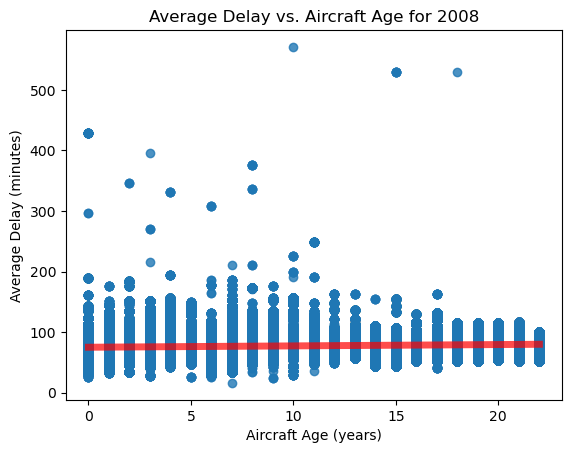

In [54]:


for year in range(1999, 2009):
    try:
        year_flight = pd.read_csv(f"{year}.csv.bz2", compression='bz2', encoding='utf-8')
    except UnicodeDecodeError:
        year_flight = pd.read_csv(f"{year}.csv.bz2", compression='bz2', encoding='ISO-8859-1')
 
    year_flight_cleaned = year_flight[(year_flight['Cancelled'] == 0) & (year_flight['Diverted'] == 0)].drop_duplicates()
    # Create data column
    year_flight_cleaned['date'] = pd.to_datetime(year_flight_cleaned.apply(lambda x: datetime.date(x['Year'], x['Month'], x['DayofMonth']), axis=1))

    delay_columns = ["ArrDelay", "DepDelay", "CarrierDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "WeatherDelay"]
    year_flight_cleaned.fillna(method='ffill', inplace=True)
 
    year_flight_cleaned['total_delay'] = year_flight_cleaned[delay_columns].sum(axis=1, skipna=True)
    year_flight_delays = year_flight_cleaned[year_flight_cleaned['total_delay'] > 0]

    planes_manu = year_flight_delays.merge(planes, left_on='TailNum', right_on='tailnum')

    planes_manu['issue_date'] = pd.to_datetime(planes_manu['issue_date'])
    
    planes_manu.dropna(subset=['issue_date', 'date'], inplace=True)

    # Calculate aircraft age
    planes_manu['AircraftAge'] = ((planes_manu['date'] - planes_manu['issue_date']) / timedelta(days=365.2425)).astype(int)

    # Calculate the mean 'total_delay' for each 'TailNum' 
    planes_manu['AvgDelay'] = planes_manu.groupby('TailNum')['total_delay'].transform('mean')

    # Filtering
    planes_manu_filtered = planes_manu.query("AircraftAge >= 0 & AircraftAge <= 22")

    # Plotting
    sns.regplot(x=planes_manu_filtered["AircraftAge"], y=planes_manu_filtered["AvgDelay"], line_kws={"color":"r","alpha":0.7,"lw":5})
    plt.title(f"Average Delay vs. Aircraft Age for {year}")
    plt.xlabel("Aircraft Age (years)")
    plt.ylabel("Average Delay (minutes)")
    plt.show()


#Part c: "For each year, fit a logistic regression model for the probability of diverted US flights using as many features as possible from attributes of the departure date, the scheduled departure and arrival times, the coordinates and distance between departure and planned arrival airports, and the carrier. Visualize the coefficients across years."

In [74]:

coefficients_list = {}


for year in range(1999, 2009):
    try:
        year_flight = pd.read_csv(f"{year}.csv.bz2", compression='bz2', encoding='utf-8')
    except UnicodeDecodeError:
        year_flight = pd.read_csv(f"{year}.csv.bz2", compression='bz2', encoding='ISO-8859-1')

        sample_fd = year_flight.sample(n=10000, replace=True)  

        year_flight_processed = (sample_fd
            .merge(airports, left_on='Origin', right_on='iata', suffixes=('', '_origin'))
            .merge(airports, left_on='Dest', right_on='iata', suffixes=('', '_dest'))
            .rename(columns={'lat_origin': 'Origin_lat', 'long_origin': 'Origin_long',
                             'lat_dest': 'Dest_lat', 'long_dest': 'Dest_long'})
            .filter(['Year', 'Month', 'DayofMonth', 'CRSDepTime', 'CRSArrTime', 'UniqueCarrier', 'Distance', 'Diverted',
                     'Origin_lat', 'Origin_long', 'Dest_lat', 'Dest_long'])
            .dropna()
            .assign(Year=lambda x: x['Year'].astype('category'),
                    Month=lambda x: x['Month'].astype('category'),
                    DayofMonth=lambda x: x['DayofMonth'].astype('category'),
                    CRSDepTime=lambda x: x['CRSDepTime'].astype('category'),
                    CRSArrTime=lambda x: x['CRSArrTime'].astype('category'),
                    UniqueCarrier=lambda x: x['UniqueCarrier'].astype('category'),
                    Diverted=lambda x: x['Diverted'].astype('category')))

        # Construct the formula for logistic regression
        formula_terms = year_flight_processed.columns.drop(['Diverted', 'Year'])  # Exclude 'Year' if it's the index
        formula = 'Diverted ~ ' + ' + '.join(formula_terms)

        try:
            # Fit the logistic regression model
            logistic_model = smf.glm(formula=formula, data=year_flight_processed, family=sm.families.Binomial()).fit()
            coefficients_list[year] = logistic_model.params
        except Exception as e:
            print(f"An error occurred while fitting the model for year {year}: {e}")


# Visualization 
if coefficients_list:
    coef_name = 'Distance'
    data_to_plot = pd.DataFrame({
        'Year': list(coefficients_list.keys()),
        'Coefficient': [coef.get(coef_name, float('nan')) for coef in coefficients_list.values()]
    }).dropna()

plt.figure(figsize(10, 6))  
sns.lineplot(data=data_to_plot, x='Year', y='Coefficient', marker='o')  
plt.title('Evolution of Distance Coefficient over Years') 
plt.xlabel('Year')  
plt.ylabel('Coefficient Estimate') 
plt.xticks(rotation=45)  
plt.grid(True) 
plt.tight_layout() 
plt.show() 




C:\Users\Trixie\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\Trixie\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\Trixie\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\Trixie\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSep

An error occurred while fitting the model for year 2001: Unable to allocate 162. MiB for an array with shape (2117, 10000) and data type float64


MemoryError: Unable to allocate 256. KiB for an array with shape (32768,) and data type float64